In [1]:
import os

os.environ['JAX_BACKEND'] = 'cpu'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp
import jax
import jax.numpy as jnp

is_dark = False
theme, cs = rp.mpl_setup(is_dark)

In [69]:
df = pd.read_pickle('~/cdv/precomputed/mp2022/raw/batch_0005.pkl').iloc[1::10]
df

,energy,dataset-id,structure,num_atoms
21491,-22.662623,mp-29009-GGA,"[[-1.9651475 2.7845605 -1.945269 ] Li, [-1.96...",7
21501,-155.189982,mp-569811-GGA,"[[-2.18038997 5.45096927 6.22349347] Yb, [ 0...",42
21511,-24.561668,mp-1100408-GGA,"[[3.101555 3.101555 3.101555] Ta, [0. 0. 0.] S...",3
21521,-16.659670,mp-984335-GGA,"[[0. 0. 0.] Pm, [3.81317 3.81317 3.81317] Er, ...",4
21531,-30.525177,mp-866110-GGA,"[[1.6970065 1.6970065 1.6970065] Ho, [5.091019...",4
...,...,...,...,...
25741,-58.996721,mp-1080493-GGA,"[[4.102842 4.102842 0. ] Y, [0. 0. 0.] Y,...",10
25751,-329.446307,mp-1212422-GGA,"[[4.274085 2.46764894 2.04299125] Ho, [ 4.27...",44
25761,-226.025037,mp-27800-GGA,"[[0. 0. 0.] K, [5.551665 5.551665 5.551665] K,...",54
25771,-98.238141,mp-1201758-GGA,"[[2.719352 6.89613527 2.2110595 ] K, [2.7193...",32


In [70]:
samp_i = np.where(df['dataset-id'].str.contains('1207373'))[0].item()
samp_i

147

In [71]:
from tqdm import tqdm
def knn_graph(struct, r_start=8, k=32):
    """returns (ijs, ims)
    ijs: nodes k
    ims: nodes k 3"""
    if r_start > 100:
        raise ValueError()
    graph_ijs = []
    graph_ims = []
    r = r_start
    for i, nbs in enumerate(struct.get_all_neighbors(r)):
        if len(nbs) < k:
            # print('Not enough neighbors, using r =', 2 * r_start)
            return knn_graph(struct, r_start=r * 2, k=k)
        
        sites, dists, idxs, ims = zip(*nbs)
            
        chosen = np.argsort(dists)[:k]
        # if i == 0:
        #     print(dists[chosen[-1]])

        graph_ijs.append(np.array(idxs)[chosen])
        graph_ims.append(np.array(ims)[chosen])

    graph_ijs = np.stack(graph_ijs).astype(np.uint16)
    graph_ims = np.stack(graph_ims).astype(np.int8)

    return {'ims': np.array(graph_ims), 'ijs': np.array(graph_ijs)}

knns = [knn_graph(struct) for struct in tqdm(df.structure)]

100%|██████████| 430/430 [00:02<00:00, 169.59it/s]


In [133]:
atom_i = 0
ij = knns[samp_i]['ijs'][atom_i]
im = knns[samp_i]['ims'][atom_i]
print(ij)
print(im.T)

struct = df.structure.iloc[samp_i]
struct

[9 8 7 6 3 3 2 2 8 9 6 7 2 2 3 3 6 7 9 8 6 7 8 9 0 0 0 0 0 0 7 6]
[[ 0 -1  0 -1  0  0  0 -1 -1  0  0 -1  0 -1 -1  1 -1  0  1 -2  0 -1  0 -1
   0  0  1 -1  1 -1  0 -1]
 [-1  0  0 -1  0 -1  0 -1 -1  0  0 -1 -1  0 -1  0  0 -1  0 -1 -1  0  0 -1
  -1  1  1 -1  0  0  1 -2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0]]


Structure Summary
Lattice
    abc : 12.598555442264118 11.914951581202272 64.57172939
 angles : 90.0 90.0 121.9167699230599
 volume : 8227.530698238736
      A : -6.29927778 -10.91066903 0.0
      B : -5.60900714 10.51214108 0.0
      C : 0.0 0.0 -64.57172939
    pbc : True True True
PeriodicSite: Na (0.0, 0.0, 0.0) [0.0, 0.0, 0.0]
PeriodicSite: Sm (0.0, 0.0, -32.29) [0.0, 0.0, 0.5]
PeriodicSite: Sm (-5.954, -0.1993, 0.0) [0.5, 0.5, 0.0]
PeriodicSite: Sm (-2.805, 5.256, 0.0) [0.0, 0.5, 0.0]
PeriodicSite: Te (0.0, 0.0, -49.66) [0.0, 0.0, 0.769]
PeriodicSite: Te (0.0, 0.0, -14.92) [0.0, 0.0, 0.231]
PeriodicSite: Te (-8.794, -0.2656, 0.0) [0.7372, 0.7399, 0.0]
PeriodicSite: Te (-3.115, -0.133, 0.0) [0.2628, 0.2601, 0.0]
PeriodicSite: Te (-7.742, -8.147, 0.0) [0.9973, 0.2601, 0.0]
PeriodicSite: Te (-4.167, 7.748, 0.0) [0.002684, 0.7399, 0.0]

In [135]:
import plotly.express as px
im_pos = struct.cart_coords[ij] + im @ struct.lattice.matrix
shift = im_pos - struct.cart_coords[[atom_i]]

xx, yy, zz = shift.T

px.scatter_3d(x=xx, y=yy, z=zz, color=ij)

In [119]:
idxs

(4, 4, 4, 7, 0, 9, 8, 6, 4, 4, 4)

In [121]:
nbs = struct.get_all_neighbors(16)[atom_i]
# nbs = sorted(nbs, key=lambda n: n.nn_distance)
sites, dists, idxs, ims = zip(*nbs)
chosen = np.argsort(dists)[:16]

np.array(idxs)[chosen]

array([4, 4, 4, 4, 4, 4, 0, 9, 8, 7, 6], dtype=int64)

In [101]:
nbs = struct.get_neighbors(struct.sites[atom_i], 32, include_image=True, include_index=True)
nbs = sorted(nbs, key=lambda n: n.nn_distance)
for nb in nbs:
    offset = np.array(nb.image) @ struct.lattice.matrix
    dist = np.linalg.norm((struct.cart_coords[nb.index] + offset) - struct.cart_coords[atom_i])
    print(nb.species, nb.index, nb.image, offset, dist, nb.nn_distance)

Te1 4 (0.0, 1.0, 0.0) [-5.60900714 10.51214108  0.        ] 11.914951581202272 11.914951581202272
Te1 4 (0.0, -1.0, 0.0) [  5.60900714 -10.51214108   0.        ] 11.914951581202272 11.914951581202272
Te1 4 (1.0, 1.0, 0.0) [-11.90828492  -0.39852795   0.        ] 11.914951710469943 11.914951710469943
Te1 4 (-1.0, -1.0, 0.0) [11.90828492  0.39852795  0.        ] 11.914951710469943 11.914951710469943
Te1 4 (1.0, 0.0, 0.0) [ -6.29927778 -10.91066903   0.        ] 12.598555442264118 12.598555442264118
Te1 4 (-1.0, 0.0, 0.0) [ 6.29927778 10.91066903  0.        ] 12.598555442264118 12.598555442264118
Na1 0 (0.0, 0.0, 1.0) [  0.           0.         -64.57172939] 14.916330358876735 14.916330358876735
Te1 8 (-1.0, 0.0, 1.0) [  6.29927778  10.91066903 -64.57172939] 15.238646457164814 15.238646457164814
Te1 9 (0.0, -1.0, 1.0) [  5.60900714 -10.51214108 -64.57172939] 15.238646457164814 15.238646457164814
Te1 7 (0.0, 0.0, 1.0) [  0.           0.         -64.57172939] 15.238646464146019 15.238646464

In [132]:
list(G.neighbors(0))

[9, 8, 7, 6, 3, 2, 0]

array([[1, 0, 1, 1, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 0, 0, 1, 1, 1, 1],
       [1, 0, 1, 1, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 0, 0, 1, 1, 1, 1],
       [1, 0, 1, 1, 0, 0, 1, 1, 1, 1],
       [1, 0, 1, 1, 0, 0, 1, 1, 1, 1],
       [1, 0, 1, 1, 0, 0, 1, 1, 1, 1]])

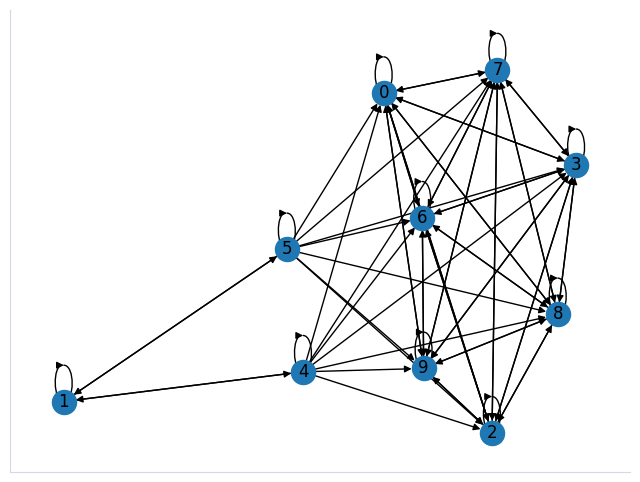

In [131]:
import networkx as nx

G = nx.DiGraph()
for i, row in enumerate(knns[samp_i]['ijs']):
    for j in row:
        G.add_edge(i, j)

nx.draw_networkx(G)
conn = np.eye(len(G.nodes)).astype(int)
for i in range(len(conn)):
    for j in range(len(conn)):
        if nx.has_path(G, i, j):
            conn[i, j] = 1

conn

In [26]:
struct = df.query('num_atoms > 8').structure.iloc[2]
struct

Structure Summary
Lattice
    abc : 6.714481 8.75801611510792 9.098840828466777
 angles : 106.90907118899793 108.46566996158978 89.262705093506
 volume : 483.71737097973164
      A : -6.714481 0.0 0.0
      B : -0.112697 -8.757291 0.0
      C : 2.881934 2.609563 8.226393
    pbc : True True True
PeriodicSite: Sb (0.0, 0.0, 0.0) [0.0, 0.0, 0.0]
PeriodicSite: Sb (1.385, -3.074, 4.113) [0.0, 0.5, 0.5]
PeriodicSite: Sb (-3.414, -4.379, 0.0) [0.5, 0.5, 0.0]
PeriodicSite: Sb (-1.916, 1.305, 4.113) [0.5, 0.0, 0.5]
PeriodicSite: Sb (-2.218, -1.815, 1.04) [0.3804, 0.2449, 0.1264]
PeriodicSite: Sb (-1.728, -4.333, 7.186) [0.6196, 0.7551, 0.8736]
PeriodicSite: Sb (-3.881, 0.1969, 6.285) [0.9025, 0.2052, 0.764]
PeriodicSite: Sb (-0.06381, -6.345, 1.942) [0.09747, 0.7948, 0.236]
PeriodicSite: Sb (2.261, -3.154, 7.246) [0.03087, 0.6226, 0.8809]
PeriodicSite: Sb (-6.206, -2.994, 0.98) [0.9691, 0.3774, 0.1191]
PeriodicSite: Sb (-2.541, -1.725, 3.906) [0.5765, 0.3385, 0.4748]
PeriodicSite: Sb (-1.404, 